In [37]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
import matplotlib.pyplot as plt

os.chdir('/Users/kaiweizhang/Desktop/IO Topic/ass1')
os.listdir()

['IO_PS_1_questions.pdf', 'product_data.csv']

In [38]:
def prepare_data(data):
    # Calculate outside good share (assuming outside share is 1 - sum of inside shares)
    outside_share = 1 - data.groupby('t')['market_share'].sum()
    data = data.merge(outside_share.reset_index().rename(columns={'market_share': 'outside_share'}), on='t')

    # Calculate log odds ratio
    data['log_odds'] = np.log(data['market_share'] / data['outside_share'])

    # Create dummy variables for diet and regular sodas
    data['Diet'] = (data['nest'] == 'Diet').astype(int)
    data['Regular'] = (data['nest'] == 'Regular').astype(int)
    return data

def get_parameters(model, nested=False, print_results=False):
    dic={}
    alpha=model.params['price']
    beta1=model.params['sugar']
    beta2=model.params['caffeine']
    gamma_D=model.params['Diet']
    gamma_R=model.params['Regular']
    dic['alpha']=alpha
    dic['beta1']=beta1
    dic['beta2']=beta2
    dic['gamma_D']=gamma_D
    dic['gamma_R']=gamma_R
    if nested:
        sigma=model.params['log_within_share']
        dic['sigma'] = sigma
    if print_results:
        print(f"alpha (price): {alpha:.4f}")
        print(f"beta1 (sugar): {beta1:.4f}")
        print(f"beta2 (caffeine): {beta2:.4f}")
        print(f"gamma_D (Diet): {gamma_D:.4f}")
        print(f"gamma_R (Regular): {gamma_R:.4f}")
        if nested:
            print(f"sigma : {sigma:.4f}")
    return dic


# Problem 1
## 1(a)

In this part I reg ln(s_jt/s_0t) to X_jt,p_jt, I_Diet, I_Regular. This means I treat xi_j as noise in regression.

The estimations are:

const      -3.044239
price      -1.626102
sugar       1.528062
caffeine    1.445800
Diet        0.603640
Regular    -3.647879

In [39]:
# Load the data
data = pd.read_csv('product_data.csv')
data=prepare_data(data)

# Prepare the design matrix X and dependent variable y
X = data[['price', 'sugar', 'caffeine', 'Diet', 'Regular']]
# X = sm.add_constant(X)  # Add a constant term to the model
y = data['log_odds']

# Fit the model
model = sm.OLS(y, X)
model_results=model.fit()

# Print the results
print(model_results.summary())

params_ols = get_parameters(model_results, nested=False, print_results=False)

                            OLS Regression Results                            
Dep. Variable:               log_odds   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     1912.
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        23:15:45   Log-Likelihood:                -1305.2
No. Observations:                1000   AIC:                             2620.
Df Residuals:                     995   BIC:                             2645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
price         -1.6261      0.021    -77.352      0.0

## 1(a)-2 
In this part I reg ln(s_jt/s_0t) to X_jt,p_jt, I_Diet, I_Regular and 9 dummies for each j (drop ID_1). This means I treat xi_j as fixed within periods in regression.

In [40]:
ID_dummies = pd.get_dummies(data['product_ID'], prefix='ID').astype(int)
ID_dummies=ID_dummies.drop('ID_1',axis=1)

X = pd.concat([X, ID_dummies], axis=1)

y = data['log_odds']

# Fit the model
model = sm.OLS(y, X)
model_results=model.fit()

# Print the results
params_ols_fixed_effect = get_parameters(model_results, nested=False, print_results=True)

alpha (price): -1.6239
beta1 (sugar): 1.5230
beta2 (caffeine): 1.4450
gamma_D (Diet): -2.3990
gamma_R (Regular): -5.5584


## 1(b)


In [41]:
# Construct instruments
data['Z1'] = data['caffeine_extract_price'] * data['caffeine']
data['Z2'] = data['corn_syrup_price'] * data['sugar']

# Prepare the data for IV regression

X = data[['sugar', 'caffeine', 'Diet', 'Regular','price']]
instruments = data[['sugar', 'caffeine', 'Diet', 'Regular', 'Z1', 'Z2']]
y = data['log_odds']

# Perform 2SLS estimation
iv_model = IV2SLS(y, X, instruments)
iv_results = iv_model.fit()

# Print the results
params_IV = get_parameters(iv_results, nested=False, print_results=True)

alpha (price): -1.2405
beta1 (sugar): 1.3486
beta2 (caffeine): 1.3318
gamma_D (Diet): -2.6493
gamma_R (Regular): -6.5599


## 1(c)
Let $M=\sum_{k\neq j} exp(\delta_k)+1$, then $\frac{\partial s_{jt}}{\partial p_{jt}}=\frac{Mexp(\delta_{jt})}{(M+exp(\delta_{jt}))^2}\alpha=\alpha s_{jt}(1-s_{jt})$

Mean own-price elasticity for Regular drinks: -4.8434
Mean own-price elasticity for Diet drinks: -3.4295


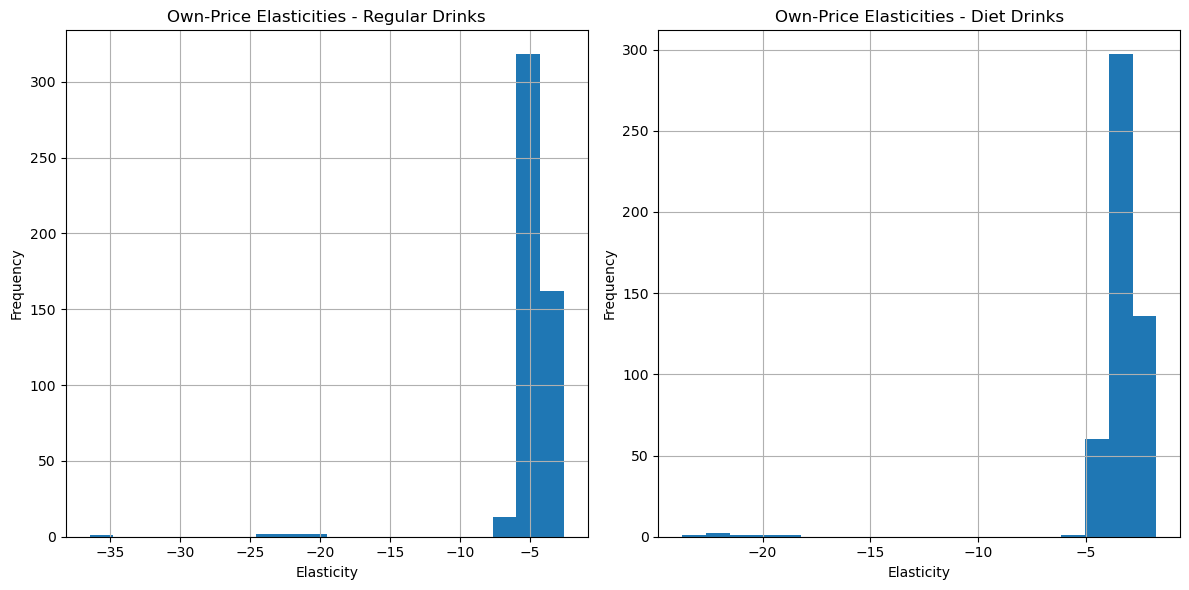

In [42]:
def own_price_derivative(alpha, s_jt):
    return alpha * s_jt * (1 - s_jt)

# Function to calculate own-price elasticity
def own_price_elasticity(alpha, p_jt, s_jt):
    return alpha * p_jt * (1 - s_jt)

# Calculate own-price derivatives and elasticities
alpha=params_ols['alpha']
data['own_price_derivative'] = own_price_derivative(alpha, data['market_share'])
data['own_price_elasticity'] = own_price_elasticity(alpha, data['price'], data['market_share'])

# Calculate mean elasticities for Regular and Diet drinks
mean_elasticity_regular = data[data['nest'] == 'Regular']['own_price_elasticity'].mean()
mean_elasticity_diet = data[data['nest'] == 'Diet']['own_price_elasticity'].mean()

print(f"Mean own-price elasticity for Regular drinks: {mean_elasticity_regular:.4f}")
print(f"Mean own-price elasticity for Diet drinks: {mean_elasticity_diet:.4f}")


# * Plot histograms of elasticities


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data[data['nest'] == 'Regular']['own_price_elasticity'].hist(bins=20)
plt.title('Own-Price Elasticities - Regular Drinks')
plt.xlabel('Elasticity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
data[data['nest'] == 'Diet']['own_price_elasticity'].hist(bins=20)
plt.title('Own-Price Elasticities - Diet Drinks')
plt.xlabel('Elasticity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1(d)
Similarly $\frac{\partial s_{jt}}{\partial p_{1t}}=-\alpha s_{jt}s_{1t}$

Mean cross-price elasticity between product 1 and Diet sodas: 0.2368
Mean cross-price elasticity between product 1 and Regular sodas: 0.4458


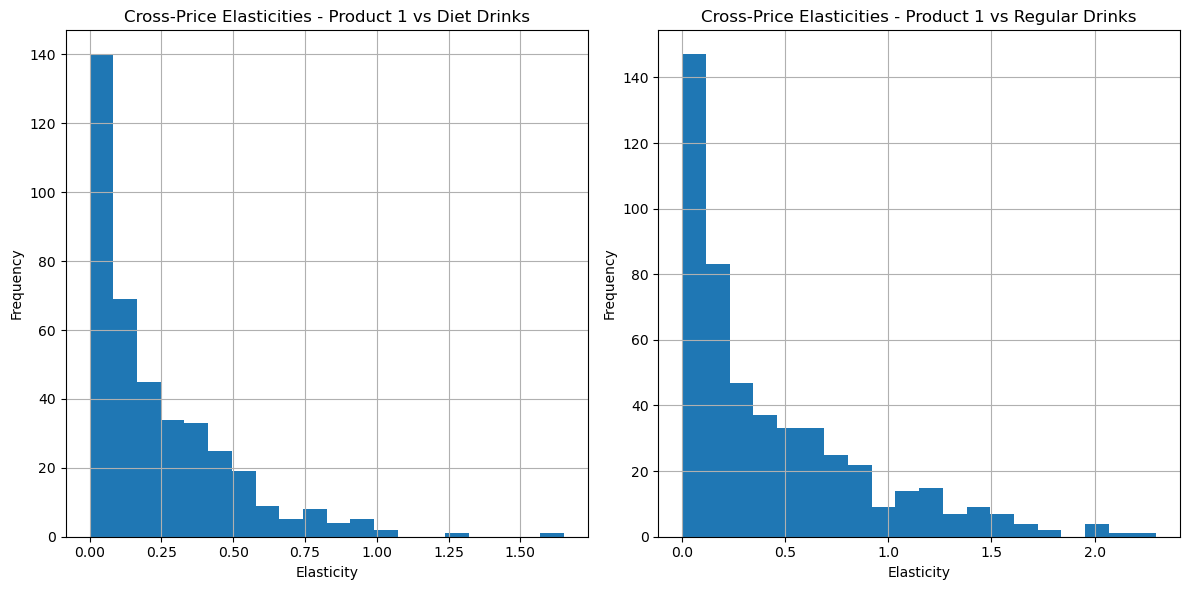

In [43]:
def cross_price_derivative(alpha, s_jt, s_it):
    return -alpha * s_jt * s_it

# Function to calculate cross-price elasticity
def cross_price_elasticity(alpha, p_1t, s_jt, s_1t):
    return -alpha * p_1t * s_jt

# Get product 1's market share for each time period
product_1_share = data[data['product_ID'] == 1].set_index('t')['market_share']

# Calculate cross-price derivatives and elasticities
data['cross_price_derivative'] = data.apply(lambda row: cross_price_derivative(alpha, row['market_share'], product_1_share[row['t']]) 
                                            if row['product_ID'] != 1 else np.nan, axis=1)

data['cross_price_elasticity'] = data.apply(lambda row: cross_price_elasticity(alpha, data.loc[(data['product_ID'] == 1) & (data['t'] == row['t']), 'price'].values[0], 
                                            row['market_share'], product_1_share[row['t']])
                                            if row['product_ID'] != 1 else np.nan, axis=1)

# Calculate mean cross-price elasticities
mean_cross_elasticity_diet = data[(data['nest'] == 'Diet') & (data['product_ID'] != 1)]['cross_price_elasticity'].mean()
mean_cross_elasticity_regular = data[(data['nest'] == 'Regular') & (data['product_ID'] != 1)]['cross_price_elasticity'].mean()

print(f"Mean cross-price elasticity between product 1 and Diet sodas: {mean_cross_elasticity_diet:.4f}")
print(f"Mean cross-price elasticity between product 1 and Regular sodas: {mean_cross_elasticity_regular:.4f}")

# * Plot histograms of cross-price elasticities
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
data[(data['nest'] == 'Diet') & (data['product_ID'] != 1)]['cross_price_elasticity'].hist(bins=20)
plt.title('Cross-Price Elasticities - Product 1 vs Diet Drinks')
plt.xlabel('Elasticity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
data[(data['nest'] == 'Regular') & (data['product_ID'] != 1)]['cross_price_elasticity'].hist(bins=20)
plt.title('Cross-Price Elasticities - Product 1 vs Regular Drinks')
plt.xlabel('Elasticity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 1(e)
Use the formula that $\frac{\partial s_{jt}}{\partial p_{it}}=-\alpha s_{jt}s_{it}$

In [44]:
def generate_jacobian(time_period, data, params):
    """
    Generate the Jacobian matrix of price derivatives for a given time period.
    I Do need market_share column in the data pd
    Returns: np.array like Jacobian matrix of price derivatives.
    """
    alpha = params['alpha']
    # Filter data for the given time period
    period_data = data[data['t'] == time_period]
    n_products = len(period_data)
    shares = period_data['market_share'].values
    
    # Initialize the Jacobian matrix
    jacobian = np.zeros((n_products, n_products))

    # Fill in the Jacobian matrix
    for i in range(n_products):
        for j in range(n_products):
            if i == j:
                # Own-price derivative
                s_it = shares[i]
                jacobian[i, i] = own_price_derivative(alpha, s_it)
            else:
                # Cross-price derivative
                s_jt=shares[j]
                s_it=shares[i]
                jacobian[i, j] = cross_price_derivative(alpha, s_jt,  s_it)
                
    
    return jacobian


# Generate Jacobian for the last time period
last_period = data['t'].max()
jacobian_last_period = generate_jacobian(last_period, data, params_IV)
print(f"Jacobian matrix for period {last_period}:")
print(np.round(jacobian_last_period, 3))

Jacobian matrix for period 100:
[[-0.073  0.     0.001  0.002  0.019  0.003  0.035  0.008  0.003  0.003]
 [ 0.    -0.002  0.     0.     0.     0.     0.001  0.     0.     0.   ]
 [ 0.001  0.    -0.013  0.     0.003  0.     0.006  0.001  0.001  0.   ]
 [ 0.002  0.     0.    -0.025  0.006  0.001  0.011  0.002  0.001  0.001]
 [ 0.019  0.     0.003  0.006 -0.229  0.012  0.135  0.029  0.012  0.011]
 [ 0.003  0.     0.     0.001  0.012 -0.047  0.022  0.005  0.002  0.002]
 [ 0.035  0.001  0.006  0.011  0.135  0.022 -0.306  0.053  0.022  0.02 ]
 [ 0.008  0.     0.001  0.002  0.029  0.005  0.053 -0.108  0.005  0.004]
 [ 0.003  0.     0.001  0.001  0.012  0.002  0.022  0.005 -0.049  0.002]
 [ 0.003  0.     0.     0.001  0.011  0.002  0.02   0.004  0.002 -0.043]]


# Compare estimations from different methods

In [ ]:
sda